### 0. Import and global variables

In [14]:
from wavescapes import *
import pylab
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc
import math


test_midi_folder = 'midiFiles/'
test_xml_folder = 'xmlFiles/'
ligeti_xml = test_xml_folder+'Ligetivol1no2.musicxml'
webern_xml = test_xml_folder + 'WebernNo1.mxl'
bach_prelude_midi = test_midi_folder + '210606-Prelude_No._1_BWV_846_in_C_Major.mid'
faust_symphony_midi = test_midi_folder+'Faust_Symphony_mov1.mid'
ave_maria_midi = test_midi_folder+'AveMaria_desPrezmid.mid'
giant_steps_midi = test_midi_folder+'giant_steps_first_chorus.mid'
chopin_midi = test_midi_folder+'chopin-prelude-op28-2.mid'
scriabin_midi = test_midi_folder+'Op74_No2_Pure.mid'

filenames_and_resolution = [(faust_symphony_midi, 1), (ave_maria_midi, 8), (bach_prelude_midi, 1),\
                            (chopin_midi, 1), (scriabin_midi, 1), (giant_steps_midi, 1),\
                            (ligeti_xml, 1), (webern_xml, .25)]

## 1. Introduction 

### 2. Keyscape and keyscape legend

/usr/local/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


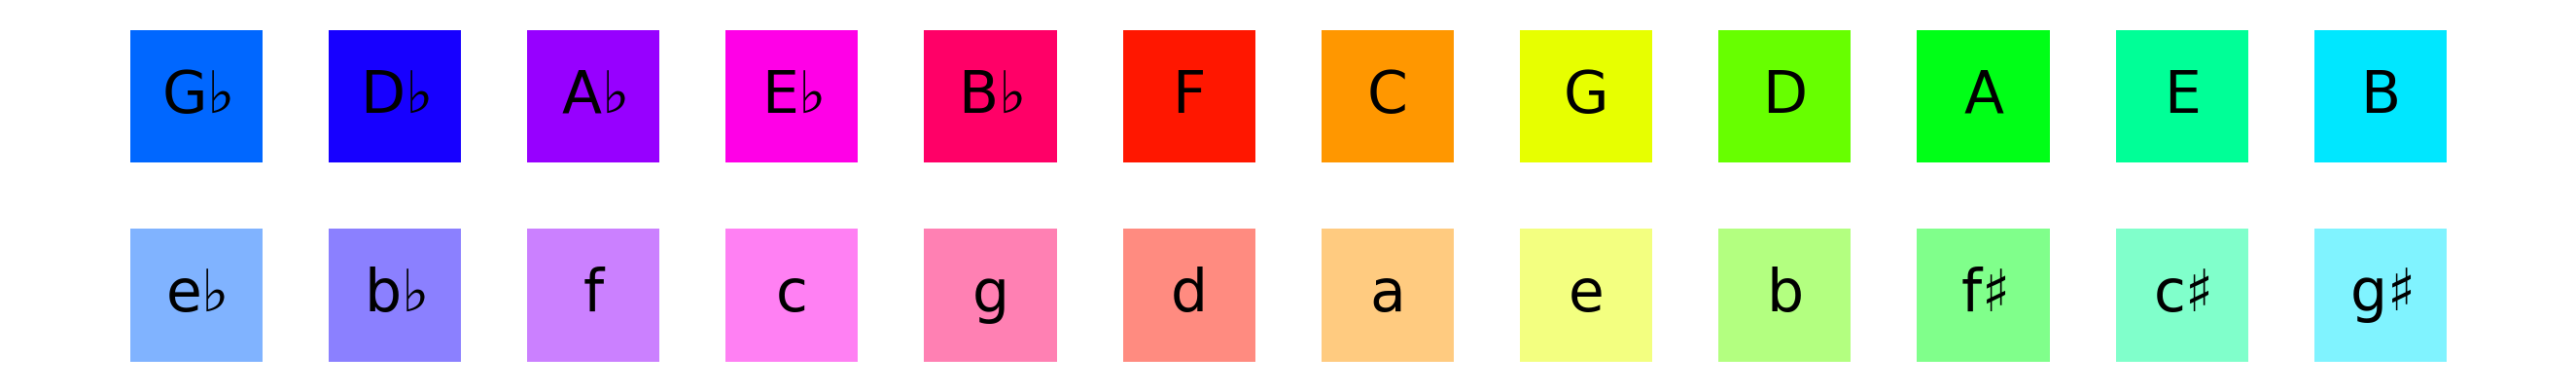

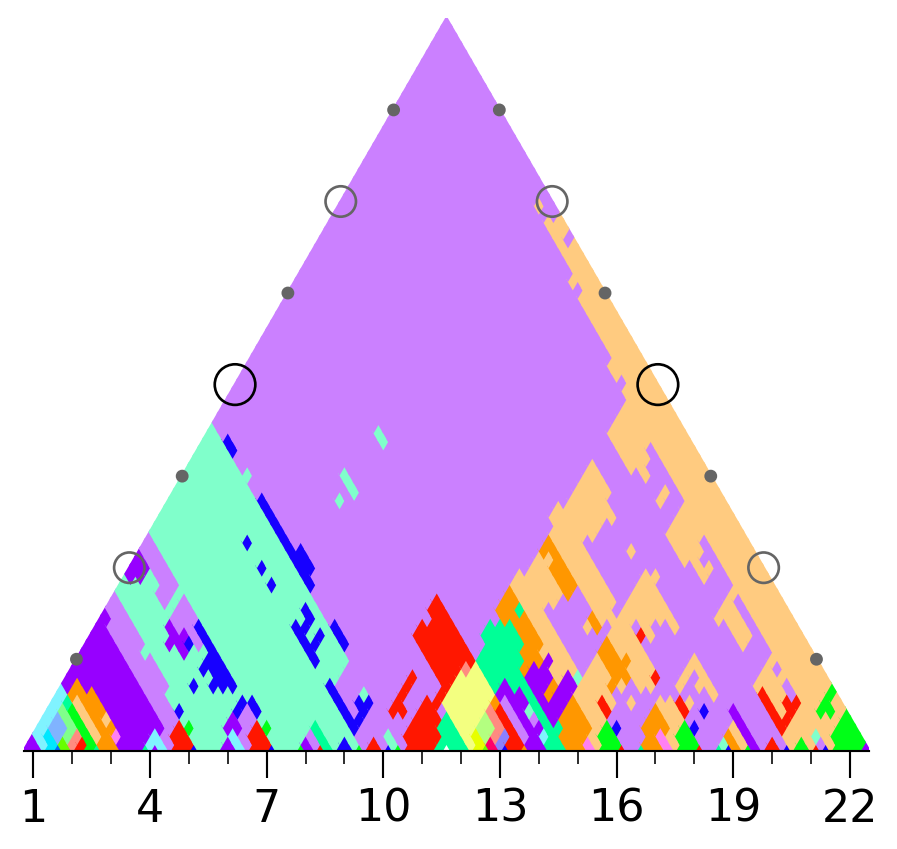

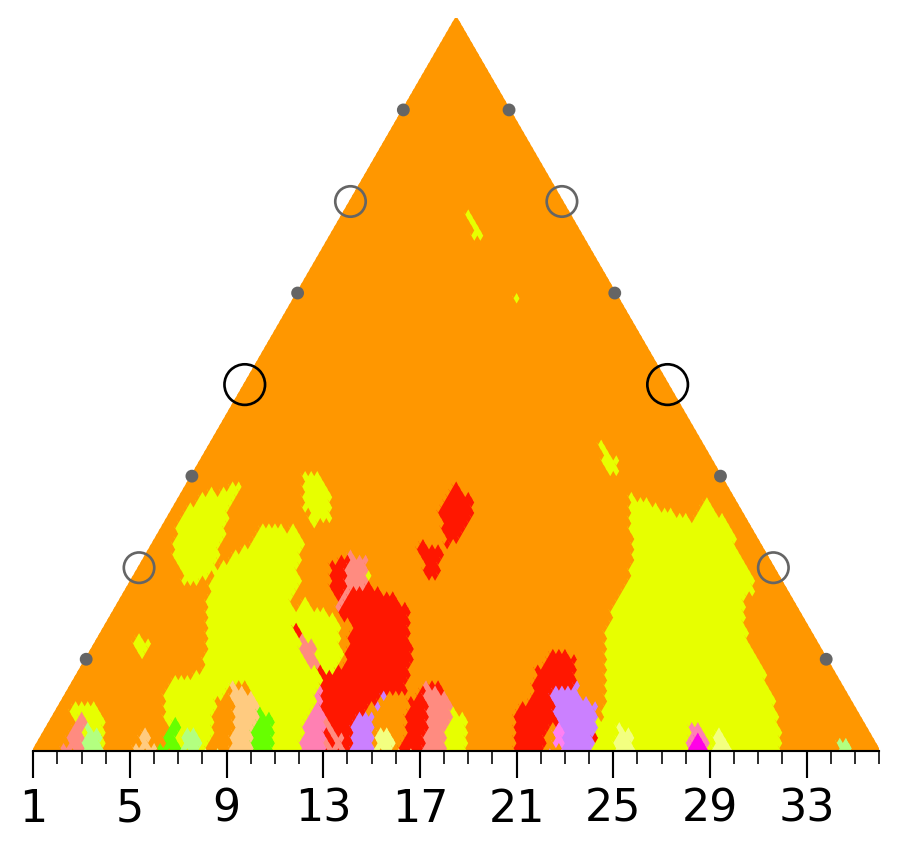

In [45]:
twelve_tones_major_key_names = ['C','D$\\flat$','D','E$\\flat$','E','F','G$\\flat$','G','A$\\flat$','A','B$\\flat$','B']
twelve_tones_minor_key_names = ['c','c$\sharp$','d','e$\\flat$','e','f','f$\sharp$','g','g$\sharp$','a','b$\\flat$','b']

krumhansl_maj = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
krumhansl_min = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

krumhansl_minor_keys = [np.roll(krumhansl_min, i) for i in range(len(krumhansl_min))]
krumhansl_major_keys = [np.roll(krumhansl_maj, i) for i in range(len(krumhansl_maj))]

def nth_coeff_phase(input_vec, n_coeff):
    assert(n_coeff <= len(input_vec))
    if not np.any(input_vec):
        return white_value
    dft_nth_coeff = np.fft.fft(input_vec)[n_coeff]
    return np.angle(dft_nth_coeff)

def rgba_to_rgb(to_convert, background):
    if len(to_convert) == 3:
        return to_convert #no point converting something that is already in RGB
    if len(to_convert) != 4:
        raise Exception('Incorrect format for the value to be converted, should have length of 4')
    if len(background) != 3:
        raise Exception('Incorrect format for the value background, should have length of 3 (no alpha channel for this one)')
    alpha = float(to_convert[3])/255.0
    return [int((1 - alpha) * background[i] + alpha * to_convert[i]) for i in range(len(background))]

stand = lambda v: int(v*0xff)

def circular_hue(angle, magnitude=1., opacity_mapping=True):
    
    #np.angle returns value in the range of [-pi : pi], where the circular hue is defined for 
    #values in range [0 : 2pi]. Rather than shifting by a pi, the solution is for the negative
    #part to be mapped to the [pi: 2pi] range which can be achieved by a modulo operation.
    def two_pi_modulo(value):
        return np.mod(value, 2*math.pi)
    
    def step_function_quarter_pi_activation(lo_bound, hi_bound, value):
        #in the increasing path branch
        if value >= lo_bound and value <= lo_bound + math.pi/3:
            return ((value-lo_bound)/(math.pi/3))
        #in the decreasing path branch
        elif value >= hi_bound and value <= hi_bound + math.pi/3:
            return 1-((value-hi_bound)/(math.pi/3))
        else:
            #the case of red 
            if lo_bound > hi_bound:
                return 0 if value > hi_bound and value < lo_bound else 1
            else:
                return 1 if value > lo_bound and value < hi_bound else 0
            
    #Need to shift the value with one pi as the range of the angle given is between pi and minus pi
    #and the formulat I use goes from 0 to 2pi.
    angle = two_pi_modulo(angle)
    green = lambda a: step_function_quarter_pi_activation(0, math.pi, a)
    blue = lambda a: step_function_quarter_pi_activation(math.pi*2/3, math.pi*5/3, a)
    red = lambda a: step_function_quarter_pi_activation(math.pi*4/3, math.pi/3, a)
    value = None
    if opacity_mapping:
        value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)), stand(magnitude))
        #defautl background for the opacity is white.
        value = rgba_to_rgb(value, background=(0xff,0xff,0xff))
    else:
        value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)))
        value = rgb_to_saturated_rbg(value, magnitude)
    return value

def build_utm_from_one_row(res):
    '''
    given a NxN matrix whose first row is the only
    one that's filled with values, this function fills
    all the above row by summing for each row's element
    the two closest element from the row below. This
    method of summing builds an upper-triangle-matrix
    whose structure represent all hierarchical level.
    '''
    pcv_nmb = np.shape(res)[0]
    for i in range(1, pcv_nmb):
        for j in range(0, pcv_nmb-i):
            res[i][i+j] = res[0][i+j] + res[i-1][i+j-1]
    return res

def rgb_to_hex(rgb):
    if type(rgb) is str and rgb[0] == '#' and len(rgb) > 6:
        # we already have an hex value given let's just return it back.
        return rgb 
    elif len(rgb) == 3:
        return '#%02x%02x%02x' % (rgb[0],rgb[1],rgb[2])
    elif len(rgb) == 4:
        return '#%02x%02x%02x%02x' % (rgb[0],rgb[1],rgb[2], rgb[3])
    else:
        raise Exception('Cannot convert RGB tuple to hex value if the value given is neither in the RGB or the RGBA format.')




krumhansl_major_angle_dict = {k: nth_coeff_phase(v, 5) for k, v in zip(twelve_tones_major_key_names, krumhansl_major_keys)}
krumhansl_minor_angle_dict = {k: nth_coeff_phase(v, 5) for k, v in zip(twelve_tones_minor_key_names, krumhansl_minor_keys)}

krumhansl_major_color_dict = {k: circular_hue(v) for k,v in krumhansl_major_angle_dict.items()}
minor_colors = [circular_hue(v, magnitude=.5) for v in krumhansl_major_angle_dict.values()]
krumhansl_minor_color_dict = dict(zip(np.roll(list(krumhansl_minor_angle_dict.keys()), 3), minor_colors))


def scalar_product(input_vec, key_prof, shift_idx):
    # compute the scalar product between a pitch class (input_vec),
    # and a key profile starting at C (key_prof). The argument "shift_idx"
    # indicates at which pitch should the scalar product begin according to the 
    # key profile.
    acc = 0
    pitch_class_size = len(key_prof)
    for i in range(pitch_class_size):
        acc += input_vec[i]*key_prof[(i-shift_idx)%pitch_class_size]
    return acc


def ks_key_finding_algo(pcv, maj_prof, min_prof):
    pcv = scipy.stats.zscore(pcv)
    
    # Generate all rotations of major and minor profile given
    major = scipy.linalg.circulant(maj_prof)
    minor = scipy.linalg.circulant(min_prof)
    
    return major.T.dot(pcv), minor.T.dot(pcv)

def select_best_key_ks(input_vec, key_prof_maj, key_prof_min):
    key_idx = np.argmax(np.vstack(ks_key_finding_algo(input_vec, key_prof_maj, key_prof_min)))
    #np.argmax return only a singular index, regardless of the array shape, meaning that above 11, that
    #that means the key was identified in the second row, i.e. the minor key.
    return (key_idx % 12, key_idx < 12)   

def pitch_to_color_template_matching(pitch_class_vector, major_profile, minor_profile, major_colors, minor_colors):
    if not np.any(pitch_class_vector):
        #this means the vector only has 0 values.
        return [255,255,255]
    key, is_major = select_best_key_ks(pitch_class_vector, major_profile, minor_profile)
    pitch_to_rgb = None
    if is_major:
        pitch_to_rgb = major_colors.values() 
    else:
        m = list(minor_colors.values())
        #centering the minor color on C for consistency with the rest of the code. 
        pitch_to_rgb = m[3:]+m[:3]
        
    indexes = [i for i in range(len(pitch_to_rgb))]
    index_to_rgb = dict(zip(indexes, pitch_to_rgb))
    return index_to_rgb[key]

krumhansl_color_mapping = lambda pcv: pitch_to_color_template_matching(pcv, krumhansl_maj, krumhansl_min, krumhansl_major_color_dict, krumhansl_minor_color_dict)

def pcv_array_to_keyscape(pcv_array, color_mapping):
    pcv_nmb = len(pcv_array)
    
    res_vector = np.full((pcv_nmb, pcv_nmb, 12), 0.0, np.float64)
    res_vector[0] = pcv_array
    pcv_mat = build_utm_from_one_row(res_vector)
    
    res_mat = np.full((pcv_nmb, pcv_nmb, 3), (0xff), np.uint8)
    for i in range(0, pcv_nmb):
        for j in range(0, pcv_nmb):
            color = color_mapping(pcv_mat[i][j])
            res_mat[i][j] = color
    return res_mat

def order_by_fifth(input_vec):
    one_elem_type = type(input_vec[0])
    zero_elem = '' if one_elem_type is str else 0
    res = [zero_elem]*len(input_vec)
    for i in range(len(input_vec)):
        curr_elem = input_vec[i]
        res[(i*7)%12] = curr_elem
    #centering on C Major
    return res[6:]+res[:6]

def color_mapping_color_legend(major_label_color_dict, minor_label_color_dict, plot_width=20):
    keys_nbr = len(major_label_color_dict)
    marker_size = (2.*(plot_width+2))/(3*(keys_nbr+1))
    plot_height = 3*marker_size
    xs = np.arange(0,plot_width,1.5*marker_size)
    bottom_y = 0
    top_y = 1.5*marker_size
    ys = [top_y, bottom_y]
    fig, ax = plt.subplots(figsize=(plot_width-1.5,plot_height))
    
    
    major_label_color = np.array([[k,v] for k,v in major_label_color_dict.items()])
    minor_label_color = np.array([[k,v] for k,v in minor_label_color_dict.items()])
    colors_mat = np.array((order_by_fifth(major_label_color[:,1]),\
                           order_by_fifth(minor_label_color[:,1])))
    labels_mat = np.array((order_by_fifth(major_label_color[:,0]), \
                           order_by_fifth(minor_label_color[:,0])))
    
    for i in range(len(ys)):
        curr_colors = colors_mat[i]
        curr_labels = labels_mat[i]
        for j in range(len(xs)):
            curr_color = rgb_to_hex(curr_colors[j])
            rect = mpl.patches.Rectangle((xs[j],ys[i]),marker_size,marker_size,linewidth=1,facecolor=curr_color)
            #ha = horizontal alignment, va = vertical alignment
            plt.text(xs[j]+marker_size/2., ys[i]+marker_size/2., curr_labels[j], va='center', ha='center', fontsize=30)#, horizontalignment='center')
            ax.add_patch(rect)
    plt.axis('off')
    pylab.axis('scaled')


color_mapping_color_legend(krumhansl_major_color_dict, krumhansl_minor_color_dict)
plt.tight_layout()
plt.savefig('color_legend.png')

pcv_array = produce_pitch_class_matrix_from_filename(faust_symphony_midi)
color_mat = pcv_array_to_keyscape(pcv_array, krumhansl_color_mapping)
ws = Wavescape(color_mat, 500, drawing_primitive='rhombus')
ws.draw(tick_ratio = 4, start_offset=1)
plt.savefig('faust_ks_kr.png')

pcv_array = produce_pitch_class_matrix_from_filename(bach_prelude_midi)
color_mat = pcv_array_to_keyscape(pcv_array, krumhansl_color_mapping)
ws = Wavescape(color_mat, 500, drawing_primitive='rhombus')
ws.draw(tick_ratio = 4)
plt.savefig('bach_ks_kr.png')

## 2. Methodology

### 2.1 heatmap

In [ ]:
nth_coeff_magn = lambda z, n: np.abs(np.fft.fft(z)[n])
total_dict = {
    'Single tone (1)' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'Tritone (2)' : [1,0,0,0,0,0,1,0,0,0,0,0],
    'Major/minor triad (3)' : [1,0,0,1,0,0,0,1,0,0,0,0],
    'Augmented triad (3)':   [1,0,0,0,1,0,0,0,1,0,0,0],
    'M7 chord (4)' : [1,0,0,0,1,0,0,1,0,0,0,1],
    'm7 chord (4)' : [1,0,0,1,0,0,0,1,0,0,1,0],
    'dom/half-dim. chord (4)' :  [1,0,0,0,1,0,0,1,0,0,1,0],
    'Dim. chord (4)': [1,0,0,1,0,0,1,0,0,1,0,0],
    'Pentatonic scale (5)': [1,0,1,0,1,0,0,1,0,1,0,0],
    'Guido\'s hexachord (6)' :[1,0,1,0,1,1,0,1,0,1,0,0],
    'Whole-tone scale (6)' : [0,1,0,1,0,1,0,1,0,1,0,1],
    '6 chromatic tones (6)': [1,1,1,1,0,0,0,0,0,0,1,1],
    'Diatonic scale (7)': [1,0,1,0,1,1,0,1,0,1,0,1],
    #'Harmonic minor scale (7)': [1,0,1,0,1,1,0,0,1,1,0,1],
    '3 chromatic tritones (6)' : [1,1,0,0,0,1,1,1,0,0,0,1],
    'Hexatonic scale (6)': [1,1,0,0,1,1,0,0,1,1,0,0],
    'Octatonic scale (8)': [1,1,0,1,1,0,1,1,0,1,1,0],
    'All tones (12)': [1,1,1,1,1,1,1,1,1,1,1,1]
}

coeffs_1_to_6 = {str(i):i for i in range(1,7)}


def heatmap_plotting(labels_in_vec_dict, coeffs_dict, normalization=True, figsize = (16, 24), epsilon=.0001):
    labelsize= 20
    plt.figure(figsize=figsize)
    mpl.rc('xtick', labelsize=labelsize) 
    mpl.rc('ytick', labelsize=labelsize)
    
    labels = list(labels_in_vec_dict.keys())
    vectors = list(labels_in_vec_dict.values())
    coeffs = list(coeffs_dict.values())
    x_len = len(labels)
    y_len = len(coeffs)
    matrice = np.full((x_len, y_len), 0.0, np.float32)
    for i in range(x_len):
        for j in range(y_len):
            vec = vectors[i]
            coeff = coeffs[j]
            norm_magn = nth_coeff_magn(vec, coeff)/(sum(vec) if normalization else 1.0)
            norm_magn = norm_magn #if norm_magn > epsilon else 0.
            matrice[i][j] = norm_magn

    cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
    ax = sns.heatmap(matrice, yticklabels=labels, xticklabels=list(coeffs_dict.keys()), square=True, cmap=cmap, annot=True, annot_kws={"size": labelsize})
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xlabel('k', fontsize=labelsize)
    return ax

heatmap_plotting(total_dict, coeffs_1_to_6)
plt.tight_layout()

### Polar representation of complex number

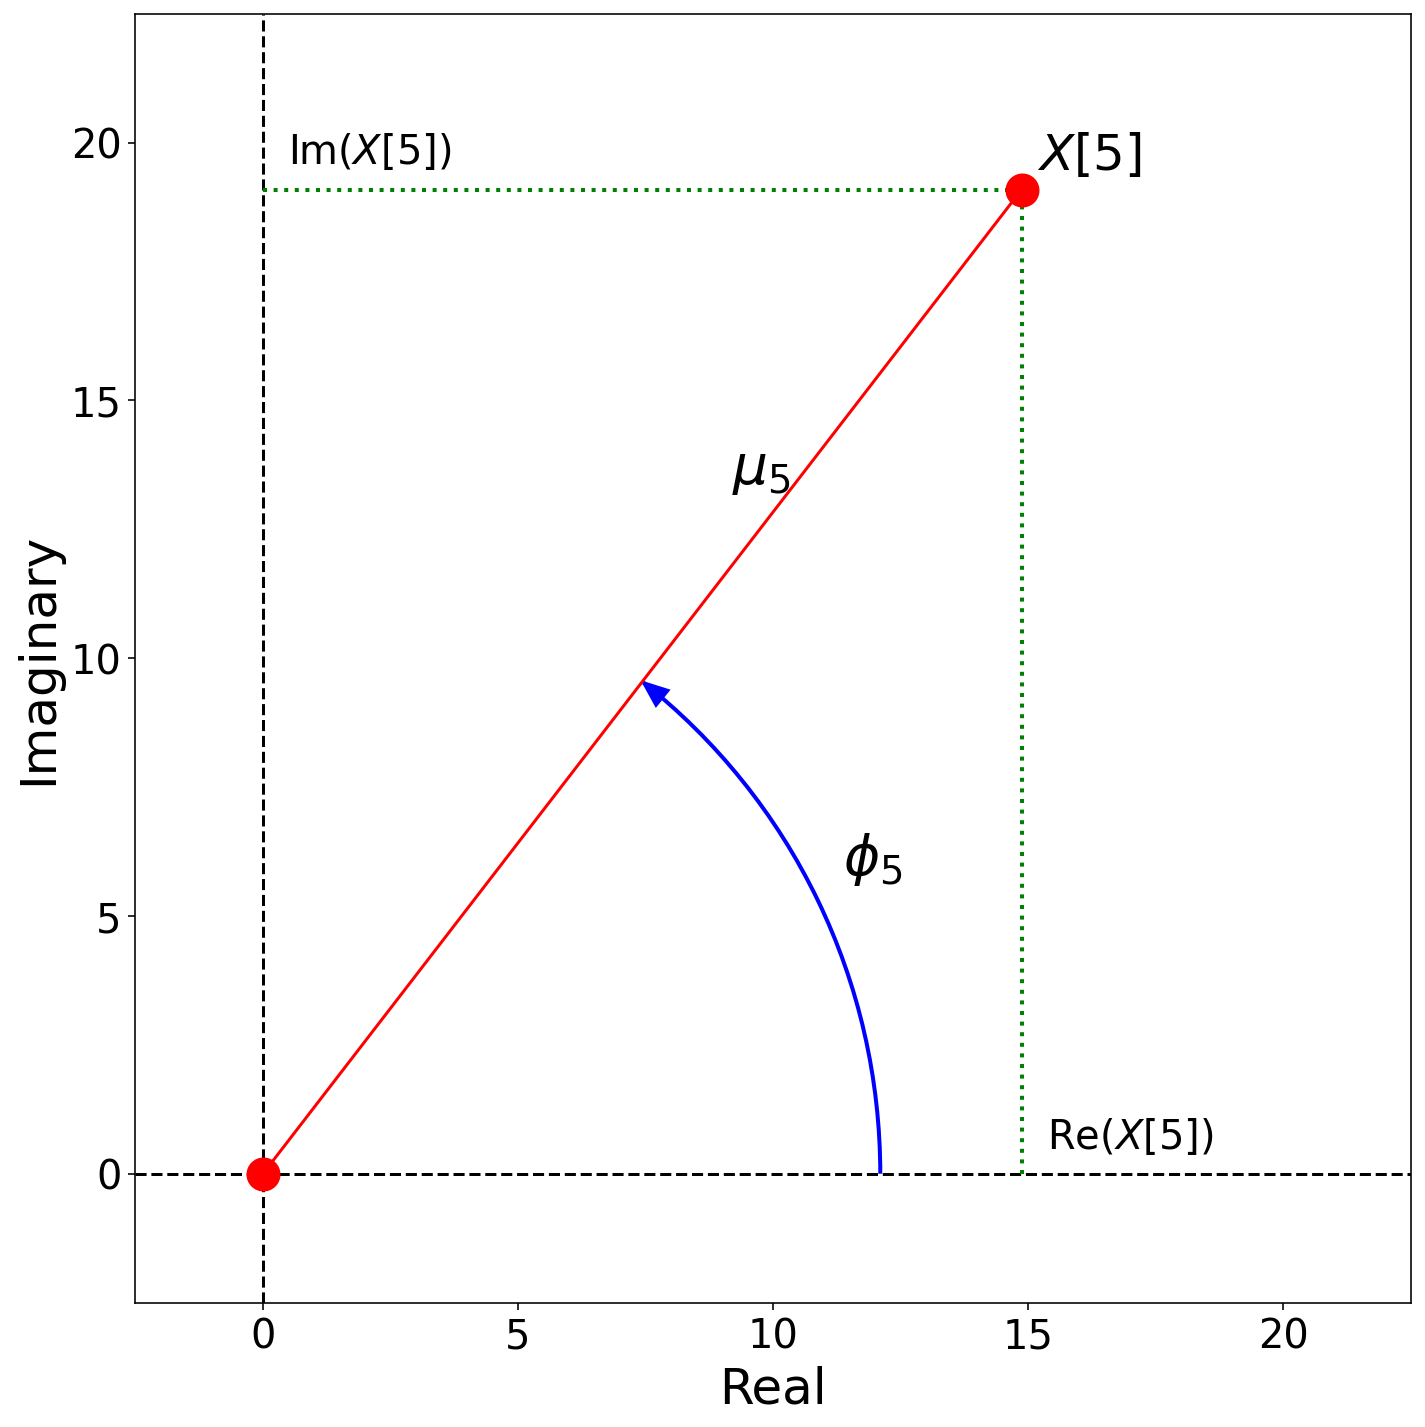

In [4]:
def argand(a, show_magn=True):
    lw = 2
    font_size = 20
    bigger_font_size = font_size*1.25
    fig, ax = plt.subplots(figsize=(font_size/2,font_size/2))
    mpl.rc('xtick', labelsize=font_size)
    mpl.rc('ytick', labelsize=font_size)
    plt.rc('axes', labelsize=font_size)
    
    x = a.real
    y = a.imag
    arc_w = np.abs(a)[0]
    angle = (np.angle(a))[0] * (180/math.pi)

    ax.axhline(0, color='black', linestyle='--')
    ax.axvline(0, color='black', linestyle='--')
    plt.grid(True)
    
     #Real line
    plt.plot((x, x), (0, y), 'k:', color='green', linewidth=lw)
    ax.text(x+.5, .5, '$\operatorname{Re}(X[5])$', fontdict={'size':font_size})
    
    
    #Imaginary line
    plt.plot((0, x), (y, y), 'k:', color='green', linewidth=lw)
    ax.text(.5, y+.5, '$\operatorname{Im}(X[5])$', fontdict={'size':font_size})
    if show_magn:
        
        label_x = (arc_w/2)*np.cos(np.angle(a)[0]/2)+.5
        label_y = (arc_w/2)*np.sin(np.angle(a)[0]/2)+.5
        ax.text(label_x, label_y, '$\phi_5$', fontdict={'size':bigger_font_size*1.1})
        
        hatf_x = (arc_w/2)*np.cos(np.angle(a)[0]+0.125) + 3
        hatf_y = (arc_w/2)*np.sin(np.angle(a)[0]+0.125)+ 3
        ax.text(hatf_x, hatf_y, '$\mu_5$', fontdict={'size':bigger_font_size*1.1})
        
        arrow_x = (arc_w/2)*np.cos(np.angle(a)[0]-0.042)
        arrow_y = (arc_w/2)*np.sin(np.angle(a)[0]-0.042)
        
        dxdy = np.array([x[0]/2, y[0]/2]) - np.array([arrow_x, arrow_y])
        arc_arrow_dx = dxdy[0]
        arc_arrow_dy = dxdy[1]
        ax.arrow(
            arrow_x,
            arrow_y,
            arc_arrow_dx*0.00001,
            arc_arrow_dy*0.00001,
            head_width=0.4,
            head_length=0.5,
            color='blue')
        arc = Arc((0,0), arc_w, arc_w, angle = 0, theta1=0, theta2=angle, color='blue', linewidth=lw)
        ax.add_patch(arc)
        
        plt.plot([0,a.real],[0,a.imag],'ro-',label='python', markersize=font_size*0.8)
    else:
        plt.scatter(a.real,a.imag, s=[font_size*10])
    
    
    coeff_x = (arc_w+0.5)*np.cos(np.angle(a)[0])
    coeff_y = (arc_w+0.5)*np.sin(np.angle(a)[0])
    ax.text(coeff_x, coeff_y, '$X[5]$', fontdict={'size':bigger_font_size})
    limit=np.min(np.floor(np.absolute(a)))-2.5 # set limits for axis
    plt.xlim((-2.5,limit+1))
    plt.ylim((-2.5,limit+1))
    plt.ylabel('Imaginary', fontdict={'size':bigger_font_size})
    plt.xlabel('Real' , fontdict={'size':bigger_font_size})
    ax.grid(False)
    plt.tight_layout()
    
argand(np.array([14.87]) + 1j*np.array([19.09]), True)

### Color space empty

In [ ]:
legend_decomposition({}, single_img_coeff=1, width=7)

### Legend plots

In [ ]:


d_lbls = ['$CM$','$C{\sharp}M$','$DM$','$D{\sharp}M$','$EM$','$FM$','$F{\sharp}M$','$GM$','$G{\sharp}M$','$AM$','$A{\sharp}M$','$BM$']
CMAJ = [1,0,1,0,1,1,0,1,0,1,0,1]

dlp = {d_lbls[i]: (np.roll(CMAJ, i), [5]) for i in range(len(d_lbls))}

rest_d = {
    '$C$': ([1,0,0,0,0,0,0,0,0,0,0,0], [1,5]),
    '$C\sharp$': ([0,1,0,0,0,0,0,0,0,0,0,0], [1,5]),
    '$D$': ([0,0,1,0,0,0,0,0,0,0,0,0], [1,5]),
    '$D\sharp$': ([0,0,0,1,0,0,0,0,0,0,0,0], [1,5]),
    '$E$': ([0,0,0,0,1,0,0,0,0,0,0,0], [1,5]),
    '$F$': ([0,0,0,0,0,1,0,0,0,0,0,0], [1,5]),
    '$F\sharp$': ([0,0,0,0,0,0,1,0,0,0,0,0], [1,5]),
    '$G$': ([0,0,0,0,0,0,0,1,0,0,0,0], [1,5]),
    '$G\sharp$': ([0,0,0,0,0,0,0,0,1,0,0,0], [1,5]),
    '$A$': ([0,0,0,0,0,0,0,0,0,1,0,0], [1,5]),
    '$A\sharp$': ([0,0,0,0,0,0,0,0,0,0,1,0], [1,5]),
    '$B$': ([0,0,0,0,0,0,0,0,0,0,0,1], [1,5]),
    '$C+$': ([1,0,0,0,1,0,0,0,1,0,0,0], [3]),
    '$C\sharp+$': ([0,1,0,0,0,1,0,0,0,1,0,0], [3]),
    '$D+$': ([0,0,1,0,0,0,1,0,0,0,1,0], [3]),
    '$D\sharp+$': ([0,0,0,1,0,0,0,1,0,0,0,1], [3]),
    '$H_{1,2}$': ([0,1,1,0,0,1,1,0,0,1,1,0], [3]),
    '$H_{2,3}$': ([0,0,1,1,0,0,1,1,0,0,1,1], [3]),
    '$H_{0,1}$': ([1,1,0,0,1,1,0,0,1,1,0,0], [3]),
    '$H_{3,0}$': ([1,0,0,1,1,0,0,1,1,0,0,1], [3]),
    '$C^{o7}$': ([1,0,0,1,0,0,1,0,0,1,0,0], [4]),
    '$C\sharp^{o7}$': ([0,1,0,0,1,0,0,1,0,0,1,0], [4]),
    '$D^{o7}$': ([0,0,1,0,0,1,0,0,1,0,0,1], [4]),
    '$O_{0,1}$': ([1,1,0,1,1,0,1,1,0,1,1,0], [4]),
    '$O_{1,2}$': ([0,1,1,0,1,1,0,1,1,0,1,1], [4]),
    '$O_{2,0}$': ([1,0,1,1,0,1,1,0,1,1,0,1], [4]),
    '$T_0$': ([1,0,0,0,0,0,1,0,0,0,0,0], [2]),
    '$T_1$': ([0,1,0,0,0,0,0,1,0,0,0,0], [2]),
    '$T_2$': ([0,0,1,0,0,0,0,0,1,0,0,0], [2]),
    '$T_3$': ([0,0,0,1,0,0,0,0,0,1,0,0], [2]),
    '$T_4$': ([0,0,0,0,1,0,0,0,0,0,1,0], [2]),
    '$T_5$': ([0,0,0,0,0,1,0,0,0,0,0,1], [2]),
    '$WT_1$': ([1,0,1,0,1,0,1,0,1,0,1,0], [6]),
    '$WT_2$': ([0,1,0,1,0,1,0,1,0,1,0,1], [6]),
    '$\Omega$': ([1,1,1,1,1,1,1,1,1,1,1,1], [0])
}

everything_d = dict(dlp, **rest_d)
        
for i in range(1,7):
    legend_decomposition(everything_d, single_img_coeff=i, width=7)
    plt.savefig('cp_'+str(i)+'.png', bbox_inches='tight')

## 3. Case Study

### 3.1 General Plots

In [ ]:
generate_all_wavescapes(scriabin_midi, indiv_w, aw_size=0.5,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

In [ ]:
indiv_w = 700

#liszt (faust)
generate_all_wavescapes(faust_symphony_midi, 'liszt',  indiv_w, aw_size=1,\
                       tick_ratio=4, start_offset=1, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#scriabin
generate_all_wavescapes(scriabin_midi, 'scriabin', indiv_w, aw_size=1,\
                       tick_ratio=2, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#bach
generate_all_wavescapes(bach_prelude_midi,'bach',indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#chopin
generate_all_wavescapes(chopin_midi, 'chopin', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#coltrane
generate_all_wavescapes(giant_steps_midi, 'coltrane', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#ligeti
generate_all_wavescapes(ligeti_midi, 'ligeti', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#desprez
generate_all_wavescapes(ave_maria_midi, 'desprez', 1500, aw_size=8,\
                       tick_ratio=1, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#ligeti
generate_all_wavescapes(ligeti_xml, aw_size=1, tick_ratio=4,\
                        individual_width=700, save_label='ligeti')

#webern
generate_all_wavescapes(webern_full, aw_size=0.25, tick_ratio=3, \
                        individual_width=700, save_label='webern')

In [ ]:
generate_all_wavescapes(ligeti_xml, individual_width=700, aw_size=1, tick_ratio=4,\
                        save_label='ligeti')

### 3.2 Highlights for different music pieces

In [ ]:
#faust 3rd coeff with RoI
generate_single_wavescape(faust_symphony_midi, pixel_width=indiv_w, aw_size=1,\
                          coefficient=3, tick_ratio=4, start_offset=1, subparts_highlighted=[[1,9], [9,17]])
plt.savefig('liszt3.png', bbox_inches='tight')

#scriabin 4tch coeff with RoI
generate_single_wavescape(scriabin_midi, pixel_width=indiv_w, aw_size=1,\
                          coefficient=4, tick_ratio=4, start_offset=0, subparts_highlighted=[[14, 22]])
plt.savefig('scriabin4.png', bbox_inches='tight')

In [ ]:
### 3.3 Zooms in of highlights

In [ ]:
generate_single_wavescape(faust_symphony_midi, pixel_width=indiv_w, aw_size=1,\
                          coefficient=3, tick_ratio=4, add_line=True, start_offset=1, subparts_highlighted=[1,9])
plt.savefig('fsRo1.png')

In [ ]:
generate_single_wavescape(faust_symphony_midi, pixel_width=indiv_w, aw_size=1,\
                          coefficient=3, tick_ratio=4, add_line=True, start_offset=1, subparts_highlighted=[9,17])
plt.savefig('fsRo2.png')

In [ ]:
generate_single_wavescape(scriabin_midi, pixel_width=indiv_w, aw_size=1,\
                          coefficient=4, tick_ratio=4, add_line=True, start_offset=0, subparts_highlighted=[14, 22])
plt.savefig('scriabin8to11.png')

### Appendix: Table of average magnitude

In [ ]:
twelve_tones_vector_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#','A', 'A#', 'B']

#this is to correct the name found in the outputed notes from music21 parsing of symbolic data files.
#Since this library assumes enharmonic equivalence, any note's name should be mapped to one of the twelve values
#found in 'twelve_tones_vector_name'
altered_notation_dict = {
    'C-' : 'B',
    'C--': 'A#',
    'C---': 'A',
    'C##' : 'D',
    'C###' : 'D#',
    'D-' : 'C#',
    'D--' : 'C',
    'D---' : 'B',
    'D##' : 'E',
    'D###' : 'F',
    'E-' : 'D#',
    'E--' : 'D',
    'E---' : 'C#',
    'E#' : 'F',
    'E##' : 'F#',
    'E###' : 'G',
    'F-' : 'E',
    'F--' : 'D#',
    'F---' : 'D',
    'F##' : 'G',
    'F###' : 'G#',
    'G-' : 'F#',
    'G--' : 'F',
    'G---' : 'E#',
    'G##' : 'A',
    'G###' : 'A#',
    'A-' : 'G#',
    'A--' : 'G',
    'A---' : 'F#',
    'A##': 'B',
    'A###': 'C',
    'B-' : 'A#',
    'B--' : 'A',
    'B---' : 'G#',
    'B#' : 'C',
    'B##': 'C#',
    'B###': 'D',
} 

pitch_pitch_dict = {x: x for x in twelve_tones_vector_name}

#In the end we want each string to match an index between 0 and 11, so it fits inside a 12-d vector.
pitch_index_dict = {twelve_tones_vector_name[i]:i for i in range(len(twelve_tones_vector_name))}

#So any pitch name given to this dict will be mapped to its cannonical form defined in 'twelve_tones_vector_name'
normalize_notation_dict = dict(altered_notation_dict,  **pitch_pitch_dict)

def recursively_map_offset(filepath, only_note_name=True):
    '''
    This function recursively walks through the file's  stream's elements, 
    and whenever it encounters a note, it will append its rhytmic 
    data to the pitch and then store the resulting data structure in an array.
    If a music21 element of type chord is encountered, the chord is decomposed into all
    notes it is composed by, and each of thoses notes are appended the 
    Returns the aforementionned array.
    The rhytmic data is expressed as a tuple of the offset of the beginning of the note
    and the offset of the end of the note.
    
    All temporal informations from MIDI events parsed by the music21 library are encoded
    as unit of quarter notes count, regardless of the BPM+ or the time signature.
    
    Parameters
    ----------
    filepath : str
        the path of the MIDI file to be parsed into the list of pitches and time offset.
        
    only_note_name: bool, optional 
        indicates whether the notes need to be converted from music21 object with octave indication
        to only a string indicating the pitch class name. 
        Default value is True.
        
    Returns
    -------
    iterable of tuples
        the first element of each tuple from this iterable can either be a string indicating the 
        pitch class name of an occurence of one note, or an instance of music21.note representing 
        the occurence of one note, if the parameters 'only_note_name' is set to 'False'. 
        The second half of the tuple, is a tuple itself of float values, the first indicating
        the start offset in time of the note's occurrence, while the second indicates the end
        offset in time of the note's occurrence. Both values are expressed in terms of quarter 
        note length.
        '('E', (10,11,5))' for example would be one element of this iterable, representing an E note
        which starts at the 10th quarter note of the MIDI file and stops one quarter note and half
        later in the piece. 
        
    
    '''
    midi_stream = m21.converter.parse(filepath)
    res = []
    for elem in midi_stream.recurse():
        if isinstance(elem, m21.note.Note):
            start_offset = elem.getOffsetInHierarchy(midi_stream)
            res.append((elem.name if only_note_name else elem, (start_offset, start_offset+elem.duration.quarterLength)))
        elif isinstance(elem, m21.chord.Chord):
            start_offset = elem.getOffsetInHierarchy(midi_stream)
            res += list(map(lambda r: (r.name if only_note_name else r , (start_offset, start_offset+elem.duration.quarterLength)), elem.pitches))
    return res


def remove_drums_from_midi_file(midi_filepath):
    '''
    Takes care of removing drum tracks from a midi filename.
    Work only if the MIDI file has metadata clearly indicating channels that are
    percussive. Does not remove channels of percussive instruments that are pitched
    (like the glockenspiel or the xylophone for instance).  
    
    Parameters
    ----------
    midi_filepath : str  
        the file path of the MIDI file that needs to have percussive channels removed. 
    
    Returns
    -------
    str
        A file path of the same midi file generated without the percussive channels.
        This file path leads to a temporary folder generated on the user's OS file system
        The existence of such temporary folder can not be guaranteed to last for a long
        span of time, this depends on the user's OS bahvior fir temporary folder. As such,
        the resulting file should be used as soone as possible, or moved to a permanet folder.
    
    '''
    sound = pm.PrettyMIDI(midi_filepath)
    
    #getting the track indices of unpitched "percussive" tracks. 
    drum_instruments_index = [idx for idx, instrument in enumerate(sound.instruments) if instrument.is_drum]
    for i in sorted(drum_instruments_index, reverse=True):
        del sound.instruments[i]

    folder = tempfile.TemporaryDirectory()
    temp_midi_filepath = folder.name+'tmp.mid'
    sound.write(temp_midi_filepath)
    
    return temp_midi_filepath

def slice_according_to_beat(pitch_offset_list, beat1_offset, beat2_offset):
    '''
    the beat offset must be expressed as units of quarter notes. 
    Taken are all beat which at least END AFTER the beat1, and START BEFORE the beat2
    '''
    def only_keep_pitches_in_boundaries(pitch_offset_list, beat1_offset, beat2_offset): 
        return list(filter(lambda n: n[1][1] >= beat1_offset and n[1][0] <= beat2_offset, pitch_offset_list))

    res = []
    if beat1_offset >= beat2_offset:
        return res
    for n in only_keep_pitches_in_boundaries(pitch_offset_list, beat1_offset, beat2_offset):
        start_b = n[1][0]
        end_b = n[1][1]
        
        res_n = None
        if start_b >= beat1_offset:
            if end_b > beat2_offset:
                res_n = (n[0], (start_b, beat2_offset))
            else:
                res_n = (n[0], (start_b, end_b))
        elif end_b <= beat2_offset:
            #if start_b < beat1_offset: #of course we are in this case since the first if was not triggered.
            res_n = (n[0], (beat1_offset, end_b))
        else:
            #we are thus in the case the start and end time of the note overshoot the boundaries.
            res_n = (n[0], (beat1_offset, beat2_offset))
        #normally inconsistent results should not happen, but it is possible to have a note with duration equals to 0. This line below prevents that and thus keep the things concise.
        if res_n[1][0] < res_n[1][1]:
            res.append(res_n)
    return res

def sum_into_pitch_class_vector(pitch_offset_list, start_beat, end_beat):
    pitch_class_offset = lambda t: pitch_index_dict[normalize_notation_dict[t[0]]]
    pitch_class_vec = np.zeros(12)
    for tup in pitch_offset_list:
        #we need to be sure we don't take into account the part of the note that exceed the window's size.
        min_beat = max(start_beat, tup[1][0])
        max_beat = min(end_beat, tup[1][1])
        pitch_weight = max_beat - min_beat
        pitch_class_vec[pitch_class_offset(tup)] += pitch_weight
    return pitch_class_vec


def get_max_beat(pitch_offset_list):
    return math.ceil(max(list(map(lambda r: r[1][1], pitch_offset_list))))

def pitch_class_set_vector_from_pitch_offset_list(pitch_offset_array, aw_size=0.5): #the analysis window size (aw_size) is expressed in terms of number of beat (quarter of measures in binary time signature).
    '''
    This functions transforms a list of tuples each containing the name of the pitch
    followed by its start and end in the file into a pitch class distribution with each
    pitch class given the weight corresponding to its duration in the current slice of
    temporal size aw_size.
    
    '''
    
    max_beat = get_max_beat(pitch_offset_array)
    
    if aw_size <= max_beat/2:
        chunk_number = math.ceil(max_beat/aw_size)
    else:
        raise Exception('The analysis window\'s size (%lf) should not exceed half the duration of the musical piece (%lf).'%(aw_size, max_beat/2.))
    
    res_vector = np.full((chunk_number, 12), 0.0, np.float64)

    for b in range(chunk_number):
        start_beat = b*aw_size
        stop_beat = (b+1)*aw_size
        analysis_windows = slice_according_to_beat(pitch_offset_array, start_beat, stop_beat)
        pitch_class_vec = sum_into_pitch_class_vector(analysis_windows, start_beat, stop_beat)
        res_vector[b] = pitch_class_vec
    
    return res_vector


# trim the input array so that no empty vectors are located at the beginning and end of the muscial piece
def trim_pcs_array(pcvs):
    start = 0
    while not np.any(pcvs[start]):
        start += 1
    end = len(pcvs) - 1
    while not np.any(pcvs[end]):
        end -= 1
    return pcvs[start:end+1]


#temporarily removed
#def audio_int_to_float32(data, byte_width):
#    return data.astype(np.float32, order='C') / float(2**(byte_width-1))

#temporarily removed
#def audiowav_to_mono_float_array(filename):
#    sr, data = wavfile.read(filename)
#    data_dtype_str = str(data.dtype)
#    if data_dtype_str[:3] == 'int':
#        #converting the array into float
#        data = audio_int_to_float32(data, int(data_dtype_str[3:]))
#    elif data_dtype_str[:5] != 'float':
#        raise Exception('wav audio data is not in a format that can (trivially) be converted into float32')
#    channel_nbr = np.shape(data)[1]
#    if channel_nbr > 1:
#        #(super)stereo signal need to be converted into mono.
#        data = data.sum(axis=1) / channel_nbr
#    return data, sr

#temporarily removed
# "aw" in "number_of_aw" stands for analysis window. It determines how many chromagrams the signal will be discreticized into. 
#def produce_chromagrams_from_audio_file(audio_filename, aw_size):
#    audio_array, sample_ratio = audiowav_to_mono_float_array(audio_filename)
#    
#    hop_len = sample_ratio*aw_size #hop_len is the analysis window size for the chromagrams in terms of number of sample.
#    #so the result's shape is consistent with the one produced in the case of midi files.
#    return np.transpose(chroma_stft(audio_array, sample_ratio, hop_length=hop_len))

def produce_pitch_class_matrix_from_filename(filepath, remove_percussions = True, aw_size = 1., trim_extremities=True):
    '''
    This function takes a MIDI or XML file as a parameters and
    transforms it into "list of pitch class distribution"
    This list is modelised by a Nx12 matrix of float values, each 
    row of the matrix corresponds to the pitch content of one slice
    of temporal size "aw_size" from the musical content from the
    input's file. The number of row N depends on the temporal size
    of the file, and the number chosen for aw_size.
    
    Parameters
    ----------
    filepath : str 
        the path of the MID/MIDI/XML/MUSICXML file whose musical content 
        is transformed into the pitch class distribution's list.
        It should be noted that MIDI file exported by Musescore often features 
        "truncated" noteàs length for the playback to feel more natural, however this 
        affects the the Pitch Class Vectors produced from this function. For example,
        notes shorter than a sixteenth notes will simply be mapped to a weight of 0 in
        the resulting PCVs. If you use MuseScore to edit scores, always export your musical
        pieces in xml format, as this format does not suffer from those truncations. Only
        use MIDI if you are certain of the integrity of your file, or if you don't have any choices.
                 
    remove_percussions : bool, optional 
        indicates whether percussive instruments need to be removed from the mix. 
        ONLY APPLIES TO MIDI FILES CURRENTLY.
        Default value is True.
                          
    aw_size : float, optional
        means "analysis window's size", represent the size of each
        slice of pitch content from the file in terms of time. In the case 
        of MIDI file, this number represent the number of beat (a beat being
        a quarter note), and in the case of WAV file, this number represents 
        the number of seconds.
        Default value is 1 (1 quarter note, or 1 second depending on the file's type)
                
    trim_extremities : bool, optional
        inidicates whether the silences that are present at both
        extremities of the musical piece needs to be removed from the resulting list of pitch
        class distribution. Only apply to input data in symbolic format (i.e. not on real audio)
        Default value is True.
        
    
    Returns
    -------
    numpy matrix of shape Nx12 (numpy.ndarray of numpy.float64)
        This matrix holds the pitch distributions corresponding to all
        the pitch content from all non overlapping slices of aw_size size from the file
        given as argument.
    
    '''
    lower_filepath = filepath.lower()
    midi_extensions = ('.mid', '.midi')
    xml_extensions = ('.mxl', '.xml', '.musicxml')
    
    if lower_filepath.endswith(midi_extensions) or lower_filepath.endswith(xml_extensions):
        
        #percussion filtering only for midi files for now.
        if lower_filepath.endswith(midi_extensions) and remove_percussions:
            filepath = remove_drums_from_midi_file(filepath)
        
        pitch_offset_list = recursively_map_offset(filepath)
        pcvs_arr = pitch_class_set_vector_from_pitch_offset_list(pitch_offset_list, aw_size)
        return trim_pcs_array(pcvs_arr) if trim_extremities else pcvs_arr
    #temporarily removed.
    #elif filepath.endswith('.wav'):
    #    return produce_chromagrams_from_audio_file(filepath, aw_size)
    else:
        raise Exception('The file should be in MIDI or XML format')


import scipy

def zeroth_coeff_cm(value, coeff):
    zero_c = value[0].real
    if zero_c == 0.:
        #empty pitch class vector, thus returns null value.
        return (0.,0.)
    nth_c = value[coeff]
    magn = np.abs(nth_c)/zero_c
    angle = np.angle(nth_c)
    return (angle, magn)

res = []

for f, r in filenames_and_resolution:
    pc_mat = produce_pitch_class_matrix_from_filename(f, aw_size = r)
    fourier_mat = apply_dft_to_pitch_class_matrix(pc_mat)
    shape_x, shape_y = np.shape(fourier_mat)[:2]
    print(f)
    one_res = [f.split('/')[1].split('.')[0].replace('_', ' ')]
    for coeff in range(1,7):
        all_magn = []
        for y in range(shape_y):
            for x in range(shape_x):
                _, magn = zeroth_coeff_cm(fourier_mat[y][x], coeff)
                if magn > 0.:
                    all_magn.append(magn)

        stats = scipy.stats.describe(all_magn)
        magn_str = '{:.3f}'.format(stats.mean).lstrip('0')
        var_str = '{:.3f}'.format(stats.variance).lstrip('0')
        one_res.append('$%s(\pm%s)$'%(magn_str, var_str))
        #print('coeff %d - avg: %.4f, std_dv: %.4f'%(coeff, stats.mean, stats.variance))
    res.append(one_res)
    
import pandas as pd
df = pd.DataFrame(res)
#new_header = df.iloc[0] #grab the first row for the header
#df = df[1:] #take the data less the header row
#df.columns = new_header
#print(df.to_latex().replace('textbackslash ', '').replace('\$', '$'))

In [ ]:
print(df.set_index(0).to_latex().replace('textbackslash ', '').replace('\$', '$'))
